<a href="https://colab.research.google.com/github/vkth7/Going-Deeper-CV-/blob/main/GD2/%5BGD2%5D%20CutMix%20%EB%98%90%EB%8A%94%20Mixup%20%EB%B9%84%EA%B5%90%EC%8B%A4%ED%97%98%20%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteULZR26/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteULZR26/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


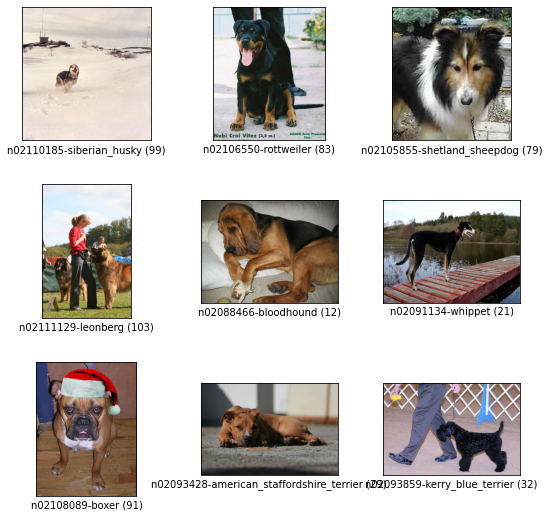

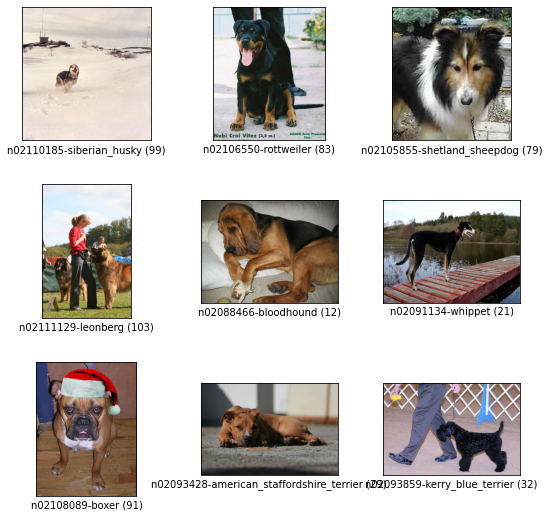

In [ ]:
tfds.show_examples(ds_train, ds_info)

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # mix two labels
        def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max):
            image_size_x = image_a.shape[1]
            image_size_y = image_a.shape[0] 
            mixed_area = (x_max-x_min)*(y_max-y_min)
            total_area = image_size_x*image_size_y
            ratio = tf.cast(mixed_area/total_area, tf.float32)
            if len(label_a.shape)==0:
                label_a = tf.one_hot(label_a, num_classes)
            if len(label_b.shape)==0:
                label_b = tf.one_hot(label_b, num_classes)
                mixed_label = (1-ratio)*label_a + ratio*label_b
            return mixed_label

        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes

ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
EPOCH=20

In [ ]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 175s 207ms/step - loss: 3.8926 - accuracy: 0.1972 - val_loss: 3.0345 - val_accuracy: 0.2599
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 3.0483 - accuracy: 0.3977 - val_loss: 1.3584 - val_accuracy: 0.6166
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7628 - accuracy: 0.4845 - val_loss: 1.2299 - val_accuracy: 0.6537
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.6101 - accuracy: 0.5353 - val_loss: 1.5639 - val_accuracy: 0.5746
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.4466 - accuracy: 0.5847 - val_loss: 1.2368 - val_accuracy: 0.6637
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3349 - accuracy: 0.6206 - val_loss: 1.2414 - val_accuracy: 0.6611
Epoch 7/20
750/750 [==============================] - 156s 209ms/step - loss: 2.2580 - accuracy: 0.6429 - val_loss: 1.2003 - val_accura

In [ ]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 164s 210ms/step - loss: 3.7848 - accuracy: 0.2187 - val_loss: 3.5403 - val_accuracy: 0.1827
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 2.9679 - accuracy: 0.4446 - val_loss: 1.4702 - val_accuracy: 0.5808
Epoch 3/20
750/750 [==============================] - 157s 209ms/step - loss: 2.7037 - accuracy: 0.5314 - val_loss: 1.3288 - val_accuracy: 0.6280
Epoch 4/20
750/750 [==============================] - 157s 210ms/step - loss: 2.5285 - accuracy: 0.5924 - val_loss: 1.3403 - val_accuracy: 0.6242
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3961 - accuracy: 0.6485 - val_loss: 1.1857 - val_accuracy: 0.6700
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2804 - accuracy: 0.6908 - val_loss: 1.3366 - val_accuracy: 0.6371
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 2.2164 - accuracy: 0.7165 - val_loss: 1.1566 -

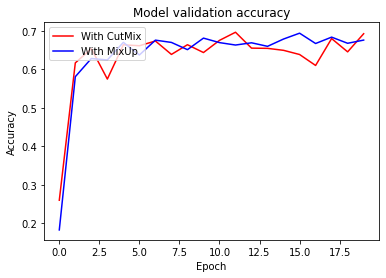

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'With MixUp', 'With CutMix and MixUp'], loc='upper left')
plt.show()

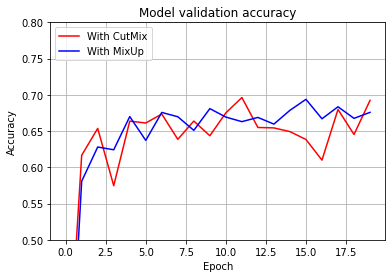

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'With MixUp', 'With CutMix and MixUp'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)
plt.show()

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 178s 228ms/step - loss: 2.2605 - accuracy: 0.4354 - val_loss: 2.7139 - val_accuracy: 0.3159
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.9287 - accuracy: 0.7284 - val_loss: 1.2418 - val_accuracy: 0.6400
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.4742 - accuracy: 0.8756 - val_loss: 1.1397 - val_accuracy: 0.6740
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2418 - accuracy: 0.9457 - val_loss: 1.0030 - val_accuracy: 0.7128
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1233 - accuracy: 0.9785 - val_loss: 0.9801 - val_accuracy: 0.7189
Epoch 6/20
750/750 [==============================] - 171s 227ms/step - loss: 0.0721 - accuracy: 0.9897 - val_loss: 1.0389 - val_accuracy: 0.7109
Epoch 7/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0718 - accuracy: 0.9884 - val_loss: 0.9901 -

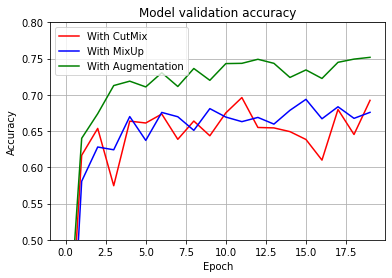

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With CutMix', 'With MixUp', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)
plt.show()

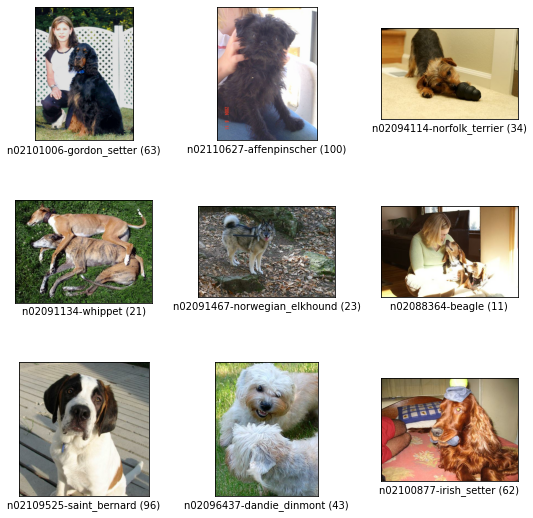

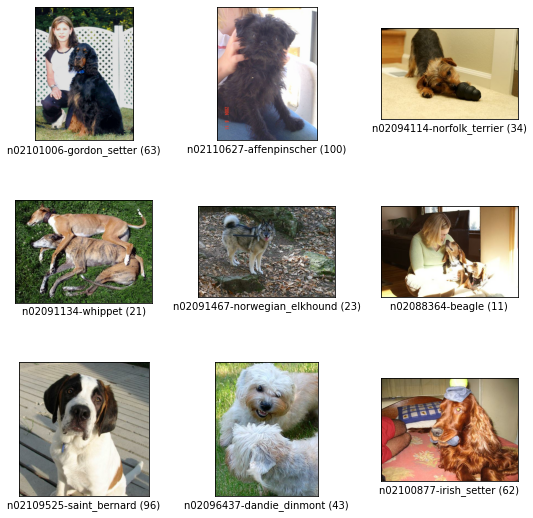

In [ ]:
tfds.show_examples(ds_train, ds_info)

사진을 보면 n02088364-beagle(11)과 같이 사람이 사진 상에 